In [1]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
keywords = pd.read_csv('keywords_preprocessed.csv')
meta = pd.read_csv('movies_metadata_preprocessed.csv')
ratings = pd.read_csv('ratings_preprocessed.csv')

In [3]:
df_numeric = meta[['budget','popularity','revenue','runtime','vote_average','vote_count']]
df_numeric.dropna(inplace=True)

train,test = train_test_split(df_numeric,test_size=0.25)

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
x = train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_numeric.columns

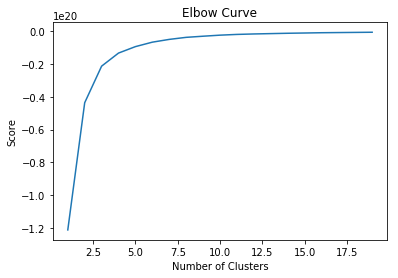

In [5]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
y = np.array(train.revenue).reshape(-1,1)
score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit(y).predict(y)
train['cluster'] = kmeans.labels_


/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
[len(train[train.cluster==i]) for i in range(4)]

[31891, 291, 1230, 88]

In [8]:
[train[train.cluster==i].revenue.mean() for i in range(4)]

[8647993.942253307, 357976533.8927835, 121761333.1052032, 830759991.8522727]

In [9]:
train.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count
cluster,,,,,,
0,5.370570e+06,2.413693,8.647994e+06,93.168762,5.603587,46.332727
1,8.998567e+07,15.315478,3.579765e+08,115.738832,6.523368,2302.340206
2,4.232640e+07,10.886648,1.217613e+08,121.295935,6.322846,856.539837
3,1.553807e+08,42.800296,8.307600e+08,128.147727,6.951136,5137.170455


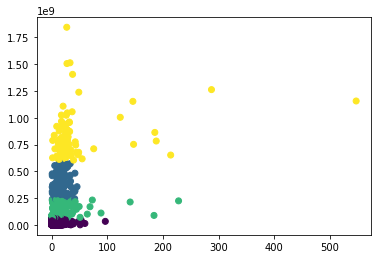

In [10]:
size_array = list(train.groupby(['cluster']).count()['revenue'].values)
train[train['cluster']==size_array.index(sorted(size_array)[0])].revenue.mean()
plt.scatter(train.popularity,train.revenue,c=kmeans.labels_)
plt.show()

In [11]:
cluster1 = train[train.cluster==1]
cluster1 = cluster1[cluster1.revenue!=0]
len(cluster1)

291

In [12]:
test_clusters = kmeans.predict(test.revenue.values.reshape(-1,1))
test['cluster'] = test_clusters
print(train.groupby(['cluster']).mean())
print(test.groupby(['cluster']).mean())

               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        5.370570e+06    2.413693  8.647994e+06   93.168762      5.603587   
1        8.998567e+07   15.315478  3.579765e+08  115.738832      6.523368   
2        4.232640e+07   10.886648  1.217613e+08  121.295935      6.322846   
3        1.553807e+08   42.800296  8.307600e+08  128.147727      6.951136   

          vote_count  
cluster               
0          46.332727  
1        2302.340206  
2         856.539837  
3        5137.170455  
               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        5.356756e+06    2.451821  8.746525e+06   92.451549      5.595282   
1        8.647384e+07   17.507276  3.583654e+08  119.091667      6.580000   
2        4.211883e+07   10.071668  1.156515e+08  118.667526      6.290464   
3        1.601

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

X = train[['budget','popularity','runtime','vote_average','vote_count']]
# y = (train[['revenue']])
y = np.log(train[['revenue']])
print(y)
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
pred = pd.DataFrame(predictions,columns=["revenue"])
y['revenue_pred'] = predictions
y = y[y.revenue_pred>0]

# log_y = np.log10(y.revenue)
# log_y_pred = np.log10(y.revenue_pred)
# print(mean_squared_error(log_y,log_y_pred))
print(mean_squared_error(y.revenue,y.revenue_pred))

print(y)
residuals = y.revenue - y.revenue_pred
print(residuals)
# plt.scatter(y.revenue,y.revenue_pred)
# plt.scatter(residuals,y.revenue_pred)
plt.show()

print(model.score(X,y.revenue))

         revenue
22230  11.381228
28326  16.401102
2736   14.112980
27719  16.386707
25919  15.324810
9010   14.888516
43500  11.381228
25103  13.377614
12521  18.253465
7394   16.130910
28343  18.235088
11576  16.427780
4696   17.446912
10073  14.236771
12385  12.634851
40570  14.948002
42088  15.882817
11999  13.035131
37628  13.791024
5456   12.426027
41916  14.858580
22476  14.874973
2648   17.021677
21718  14.510196
21522  15.453221
26091  16.389691
31723  12.755595
17052  14.109176
34799  12.655745
41775  15.837135
...          ...
34227  12.335220
18665  14.689931
27960  14.949928
10284  16.521905
43221  17.151073
13171  16.034342
14620  15.804467
1409   16.401102
29316  14.168533
29268  15.781928
33462  12.792798
9797   14.933050
18881  15.416395
27544  11.779443
37089  15.154199
11197  16.543683
31707  15.769737
29985  15.185589
29664  14.850020
43791  14.510852
9509   16.021680
43610  15.648080
44500  13.527560
29103  15.895940
28193  15.237303
34656  16.401102
766    14.0961

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:539: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
